# Classification experiment of single (cutted) cells

In [1]:
%reload_ext autoreload
%autoreload 2
from fastai import *
from fastai.vision import *
path = Path('./')

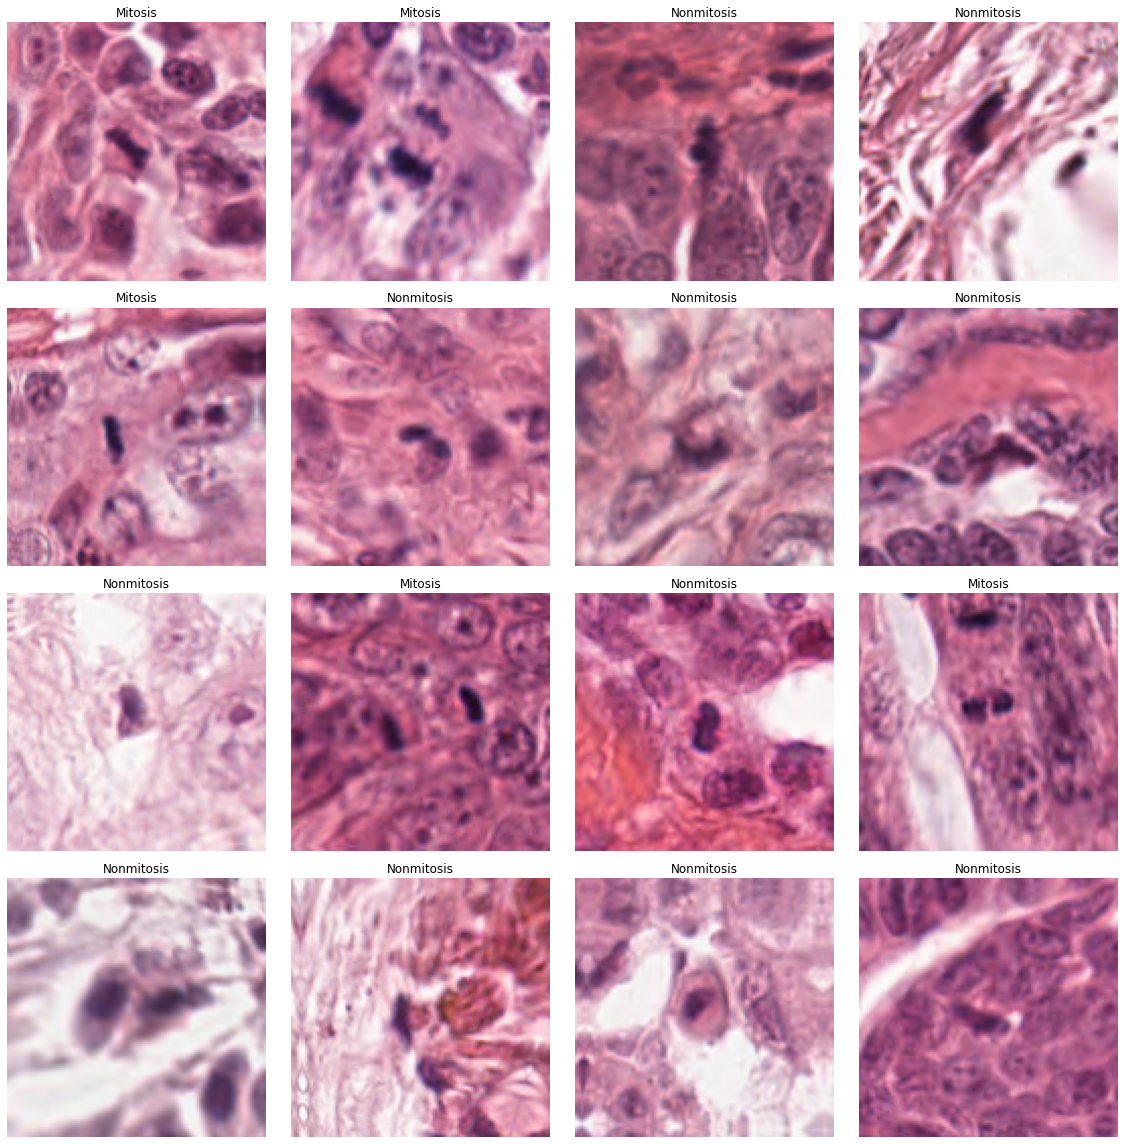

In [2]:
bs=16
data = ImageDataBunch.from_folder(Path('./Data_CMC_MEL1/'),
        ds_tfms=get_transforms(), valid_pct=0.2, size=128, train='train', num_workers=4, bs=bs, test="test").normalize()

data.show_batch(rows=4)

In [3]:
data_test = (ImageList.from_folder(Path('./Data_CMC_MEL1/'))
        .split_by_folder(train='train', valid='test')
        .label_from_folder()).databunch().normalize()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


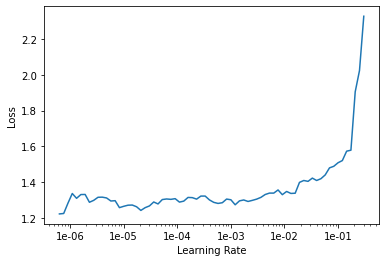

In [4]:
from fastai.callbacks import SaveModelCallback
learn = cnn_learner(data, models.resnet18, metrics=accuracy, callback_fns=[ShowGraph])
osc = callbacks.OverSamplingCallback(learn)
learn.callbacks.append(osc)
learn.callbacks.append(SaveModelCallback(learn, every='improvement'))

lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.562957,0.565537,0.710174,00:43


Better model found at epoch 0 with valid_loss value: 0.5655369758605957.


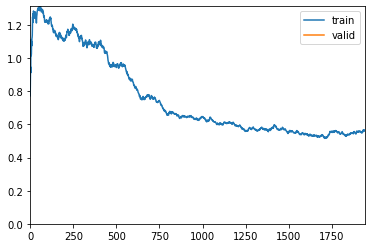

In [5]:
learn.fit_one_cycle(1,1e-3)

Unfreeze backbone of model, train for 3 cycles of 10 epochs each

epoch,train_loss,valid_loss,accuracy,time
0,0.399818,0.441840,0.784154,00:52
1,0.397492,0.405925,0.831894,00:52
2,0.357597,0.374678,0.843406,00:53
3,0.314545,0.312064,0.863552,00:53
4,0.301775,0.344887,0.841883,00:53
5,0.279722,0.335645,0.845099,00:53
6,0.220735,0.331375,0.862875,00:54
7,0.229930,0.316627,0.858812,00:54
8,0.245558,0.324241,0.853394,00:54
9,0.201433,0.328090,0.850008,00:54


Better model found at epoch 0 with valid_loss value: 0.44184017181396484.


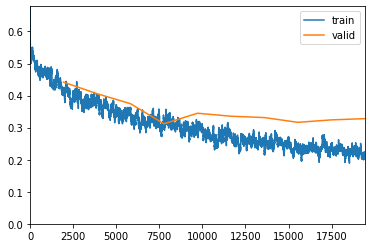

Better model found at epoch 1 with valid_loss value: 0.4059252142906189.
Better model found at epoch 2 with valid_loss value: 0.37467753887176514.
Better model found at epoch 3 with valid_loss value: 0.3120644688606262.


In [6]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4,1e-3), pct_start=0.05)


In [7]:
learn.data = data_test
#learn.validate(data.test_dl)
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
losses,idxs = interp.top_losses()


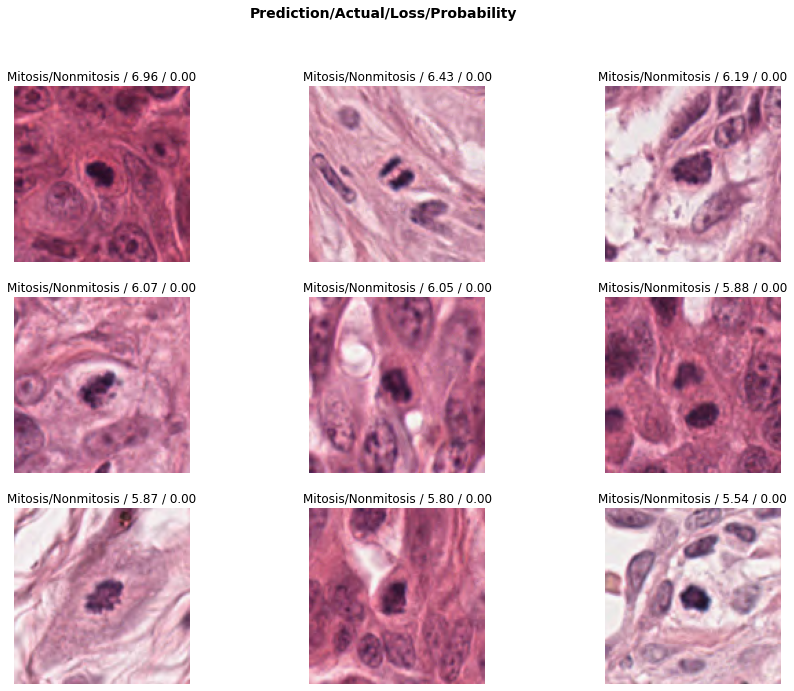

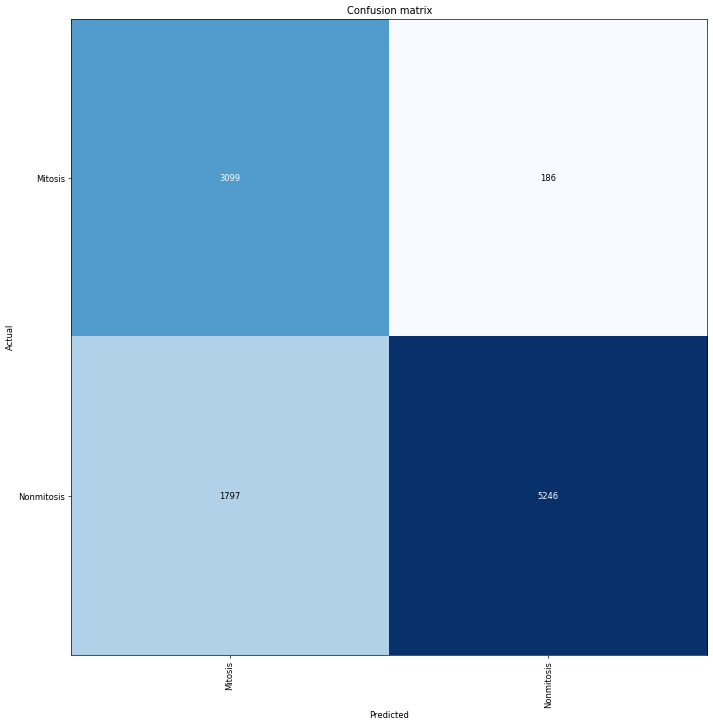

In [8]:
len(data.test_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Print confusion matrix, LaTeX style

In [9]:

print(" \\\\\n".join([" & ".join(map(str,line)) for line in interp.confusion_matrix()]))

3099 & 186 \\
1797 & 5246


## Find out test accuracy

In [10]:
c = interp.confusion_matrix()
accuracy = np.sum(c*np.eye(2))/np.sum(c)
print('Test accuracy: ',accuracy)

Test accuracy:  0.8079976762199845


In [11]:
learn.save('CellClassifier_128px_MEL_b1.pth')
learn.export('CellClassifier_128px_MEL_b1.pth')